# Grid Data Extraction

We will extract the DEM's for each grid in the filtered grid shapefile.

1. Open the ArcticDEM Strip Shapefile
2. Open the filtered grid shapefile
3. Filter the Strip shapefile to only include DEMs which intersect the grids (this reduces the Strip count to 378)

## Imports

In [136]:
!pip install pandarallel --user

  Created wheel for pandarallel: filename=pandarallel-1.4.5-cp36-none-any.whl size=16025 sha256=7f9b95e27c3926f0a5e0139918825564bf5300aadac447cc914062d79339dd9d
  Stored in directory: /home/jovyan/.cache/pip/wheels/fa/70/d9/6a27d7fdddb6a7c10af68fffaf6f0a96846c750a840280f7bc
Successfully built pandarallel


In [8]:
# GIS
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
import rasterio.plot
import json

# Multiprocessing 
# from functools import partial
# from multiprocessing import Pool
from pandarallel import pandarallel

# General Use
import os
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import shapely
import matplotlib.pyplot as plt

# Opening files which fail to open
import tarfile
import gzip
import urllib

In [2]:
# Load Grids
grids = gpd.read_file('../../data/shapefiles/grid_shapefile/1km_filtered/within/filtered_within.shp')
grids['id'] = grids['id'].astype(int)
grids = grids.set_index('id')

# Load Pingos
pingos = gpd.read_file('../../data/shapefiles/pingo_shapefile/Jones_2012_pingos_4326.shp')
pingos = pingos.set_index('Id')
pingos = pingos.to_crs(epsg=3413)  # match the projection of the Grids

In [3]:
print('Grids:', len(grids))
print('Pingos:', len(pingos))

Grids: 901
Pingos: 1249


### Construct a List of Intersecting Pingos for Each Grid

In [91]:
def get_pingos_within_grid(grid):
    pingos_within_grid = []
    
    for _, pingo in pingos.iterrows():
        if pingo['geometry'].intersects(grid['geometry']):
            pingos_within_grid.append(pingo.name)
    grid['pingos'] = pingos_within_grid
    return grid

pandarallel.initialize(progress_bar=True)
grids = grids.parallel_apply(get_pingos_within_grid, axis='columns')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [98]:
grids.to_pickle('../../data/grids.pkl')

## Filter the Strip Index

The ArcticDEM Strip Index contains many strips, we will filter this to our study area.

1. Apply the dx, dy ICESat corrections to the raster strips' shapely geometry.
2. Filter the strip index based on intersections of the grids.
3. Save this modified strip index to a DataFrame pickle file.

In [27]:
index = gpd.read_file('../../data/shapefiles/ArcticDEM_Strip_Index_Rel7/ArcticDEM_Strip_Index_Rel7.shp')

In [29]:
index = index[['name', 'fileurl', 'acquisitio', 'dx', 'dy', 'dz', 'geometry']]
index = index.set_index('name', drop=True)

#### Apply dx, dy offsets to strip geometry

In [62]:
index['icesat_geom'] = index.apply(lambda x: shapely.affinity.translate(x['geometry'], xoff=x['dx'], yoff=x['dy']), axis='columns')

#### Filter index for grid intersections

1. First iteration will filter for the study area (reduces 2nd iteration to 600 rasters)
2. Second iteration will look at the individual grids

In [75]:
study_area = shapely.wkt.loads('POLYGON ((-1969798.94566812 587548.583713684, -1969798.94566812 845945.32478978, -2138483.33523937 845945.32478978, -2138483.33523937 587548.583713684, -1969798.94566812 587548.583713684))')
index = index.loc[index.apply(lambda x: x['icesat_geom'].intersects(study_area), axis='columns')]

In [76]:
def check_geom(strip):
    for _, grid in grids.iterrows():
        if strip['icesat_geom'].intersects(grid['geometry']):
            return True
    return False

In [78]:
index = index.loc[index.apply(check_geom, axis='columns')]

In [80]:
index.to_pickle('../../data/strips.pkl')

## Extract Each Grid's Data

We will iterate over the Strip frame, find each grid that it intersects, and extract the data for those grids.

#### Load Data

In [2]:
grids = pd.read_pickle('../../data/grids.pkl')
strips = pd.read_pickle('../../data/strips.pkl')

pingos = gpd.read_file('../../data/shapefiles/pingo_shapefile/Jones_2012_pingos_4326.shp')
pingos = pingos.set_index('Id')
pingos = pingos.to_crs(epsg=3413)  # match the projection of the Grids

print('Grids:', len(grids))
print('Strips:', len(strips))
print('Pingos:', len(pingos))

Grids: 901
Strips: 378
Pingos: 1249


#### Function to Find Raster-Grid Intersections

In [4]:
def find_grid_intersections(raster, icesat_corrections=True):
    '''
    Given a row (Strip raster) of the index, this function returns a list of the grids it intersects.
    '''
    
    if icesat_corrections:
        geom = 'icesat_geom'
    else:
        geom = 'geometry'
        
    intersection = []
    for _, grid in grids.iterrows():
        if grid['geometry'].intersects(raster[geom]):
            intersection.append(grid)
    return intersection

#### Function to Download DEM to Temp Storage, Open, and Delete (Backup Option)

This function will only run if rasterio fails to open the DEM remotely.

In [5]:
def open_dem(raster):
    '''
    downloads file to temporary storage and then extracts the DEM, deleting afterwards
    This is used if opening with RasterIO fails    
    '''
    tempfile = urllib.request.urlretrieve(raster['fileurl'], filename=None)[0]
    
    tar = tarfile.open(tempfile)
    tar.extract(raster.name + '_dem.tif')
    src = rio.open('./' + raster.name + '_dem.tif')
    os.remove('./' + raster.name + '_dem.tif')
    return src

#### Function to Create Grid Rasters

1. Open the raster, either remotely, or if that fails, downloading it into temp storage
2. Apply the dx, dy IceSAT corrections (in progress)
3. Find the grids that intersect that raster, and iterate through them, masking the raster to the grid's geometry

Note: If the masked raster contains no data, it will be labeled "**grid_number**_NODATA.tif".

Otherwise it will be labeled "**grid_number**_dem.tif".

In [24]:
def grids_from_strip(strip):
    try:    
        rio_url = 'tar+' + strip['fileurl'] + '!' + strip.name + '_dem.tif'
        src = rio.open(rio_url)
    except:  # if the file fails to open
        src = open_dem(strip)
        with open('../../data/grids_02_20_2020_subtract/' + str(strip.name) + '.txt', 'w') as dst:
            pass
        
        
    for grid in find_grid_intersections(strip):
        out_dir = '../../data/grids_02_20_2020_subtract/' + str(grid.name) + '/'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
            
        # Read a window of the dataset using the boundary box of the grid 
        b = grid['geometry'].bounds
        minx, maxx = b[0] + strip['dx'], b[2] + strip['dx']
        miny, maxy = b[1] + strip['dy'], b[3] + strip['dy']
        w = rio.windows.from_bounds(left=b[0], bottom=b[1], right=b[2], top=b[3], transform = src.transform)
        grid_crop = src.read(1, window=w)

        # Update the grid raster metadata
        out_meta = src.meta.copy()
        out_meta.update({'driver':'GTiff',
                         'height': 501,
                         'width': 501,
                         'transform': src.window_transform(w),
                         'crs': src.crs
                        })
        
        # Check if there is no data in the grid
        msk = np.ma.masked_equal(grid_crop, src.nodata)
        
        if np.all(msk.mask):  # If all of the values are True (nodata)
            outfile = out_dir + strip.name + '_NODATA.tif'
        else:
            outfile = out_dir + strip.name + '_dem.tif'
            
        with rio.open(outfile, 'w', **out_meta) as dst:
                    dst.write(grid_crop, 1)

In [9]:
pandarallel.initialize()
strips.parallel_apply(grids_from_strip, axis='columns')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


name
SETSM_GE01_20120812_10504100007CE100_1050410000778700_seg1_2m_v3.0    None
SETSM_GE01_20120812_10504100007A7300_1050410000751500_seg1_2m_v3.0    None
SETSM_GE01_20120813_1050410000870B00_1050410000847E00_seg1_2m_v3.0    None
SETSM_WV01_20130411_1020010022450500_1020010021AB8500_seg1_2m_v3.0    None
SETSM_WV01_20140708_102001002F474A00_102001003026E300_seg1_2m_v3.0    None
                                                                      ... 
SETSM_WV03_20160702_104001001F628700_104001001E518500_seg1_2m_v3.0    None
SETSM_WV03_20170630_104001002E56CA00_104001002EB78A00_seg1_2m_v3.0    None
SETSM_WV03_20150419_104001000A297D00_104001000A082F00_seg1_2m_v3.0    None
SETSM_WV03_20170617_104001002F43DB00_104001002E807C00_seg1_2m_v3.0    None
SETSM_WV03_20150513_104001000BC50400_104001000CC68D00_seg1_2m_v3.0    None
Length: 378, dtype: object

## Check DEM's which RasterIO failed to open

Some of the rasters failed to open by RasterIO, they are marked as RASTER_NAME + '.txt' in the data directory.

#### Sample Error Message
RasterioIOError: '/vsitar/vsicurl/http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/geocell/v3.0/2m/n69w156/SETSM_WV01_20130411_1020010022450500_1020010021AB8500_seg1_2m_v3.0.tar.gz/SETSM_WV01_20130411_1020010022450500_1020010021AB8500_seg1_2m_v3.0_dem.tif' not recognized as a supported file format.

In [12]:
failed = glob.glob('../../data/grids_02_17_2020/*.txt')
failed = [x[x.rfind('/')+1:x.rfind('.')] for x in failed]
print(len(failed))
fail_index = strips.loc[failed].reset_index()


38


In [13]:
fail_index['sensor'] = fail_index['name'].apply(lambda x: x.split('_')[1])

In [14]:
fail_index['sensor'].value_counts()

WV01    23
WV02     9
W1W1     2
W1W2     2
W2W2     1
WV03     1
Name: sensor, dtype: int64

## Visualize at dx, dy offsets

We write a function to plot the standard grid and the grid with offsets applied.

In [12]:
def compare_offsets(raster):
    _, file = os.path.split(raster)
    _, grid_name = os.path.split(_)
    old = os.path.join('../../data/grids/', grid_name, file)
    subtract = os.path.join('../../data/grids_02_20_2020_subtract', grid_name, file)
    
    strip = strips.loc[file[:-8]]
    print('dx:', strip['dx'])
    print('dy:', strip['dy'])

    fig, axes = plt.subplots(1,3,figsize=(12,6))
    fig.suptitle(grid_name + ' - ' + file)

    grid = grids.loc[int(grid_name)]

    rasterio.plot.show(rio.open(old), ax=axes[0])
    axes[0].set_title('Standard')

    rasterio.plot.show(rio.open(raster), ax=axes[1])
    axes[1].set_title('Offsets Applied')
    
    rasterio.plot.show(rio.open(subtract), ax=axes[2])
    axes[2].set_title('Subtract Offsets')

    for pingo in grid['pingos']:
        pingo = pingos.loc[int(pingo)]
        for ax in axes:
            ax.plot(*pingo['geometry'].exterior.xy)

    plt.show()
    

dx: -1.862
dy: -1.821


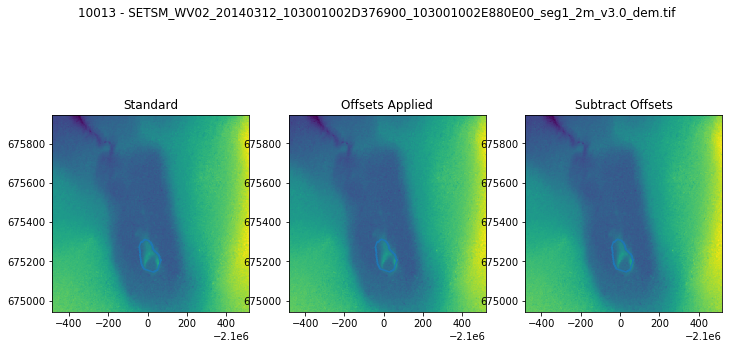

dx: -3.605
dy: 3.498


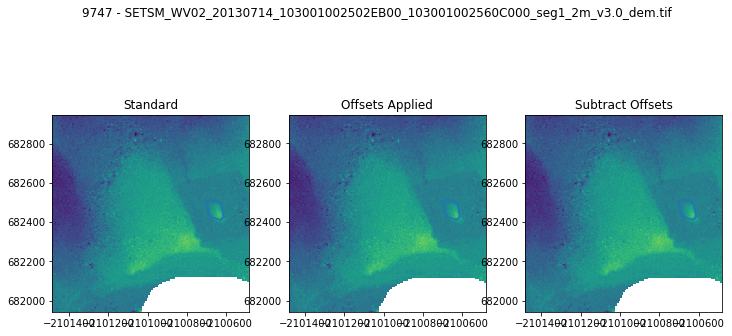

dx: -0.167
dy: -0.239


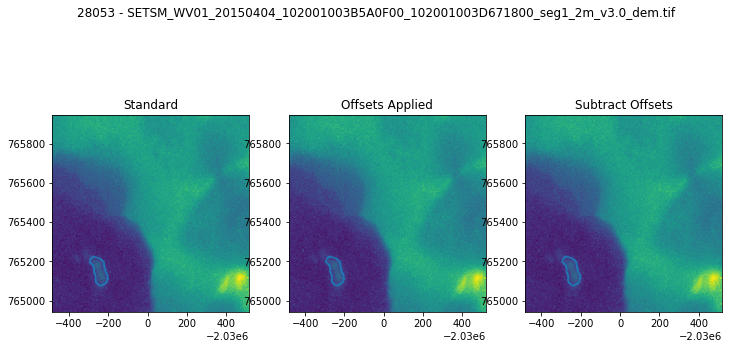

dx: 0.049
dy: -0.094


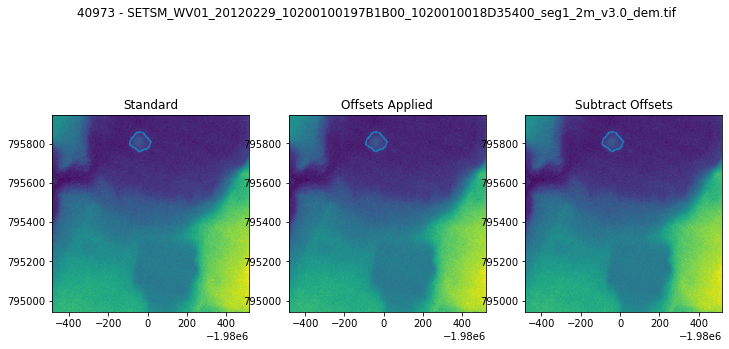

dx: 5.383
dy: 1.65


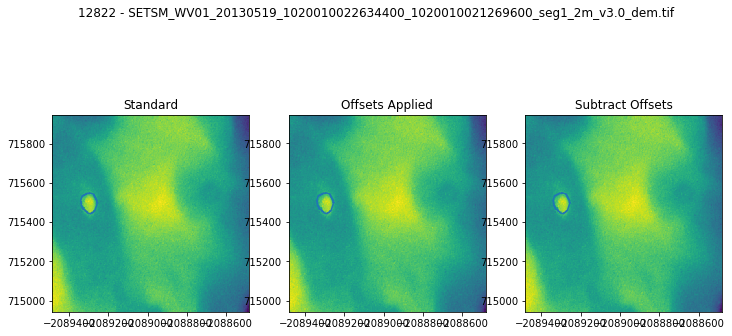

In [23]:
for raster in np.random.choice(glob.glob('../../data/grids_02_17_2020/*/*_dem.tif'), 5):
    compare_offsets(raster)